In [1]:
import os
import torch
import random

torch.cuda.manual_seed(43)
torch.manual_seed(43)
random.seed(43)

def read_data_nmt():
    """载入“英语－法语”数据集"""
    data_dir = "../dataset"
    with open(os.path.join(data_dir, 'fra.txt'), 'r',
             encoding='utf-8') as f:
        return f.read()

raw_text = read_data_nmt()
raw_text = raw_text.split('\n')
for idx, text in enumerate(raw_text):
    raw_text[idx] = text.split('CC-BY 2.0')[0]

print("总共" + str(len(raw_text)) + "组英语-法语对")
print("前5组英语-法语对示例：")

for i in range(5):
    print(raw_text[i])

raw_text = "\n".join(raw_text[:5000])

总共232737组英语-法语对
前5组英语-法语对示例：
Go.	Va !	
Go.	Marche.	
Go.	En route !	
Go.	Bouge !	
Hi.	Salut !	


In [2]:
def preprocess_nmt(text):
    """预处理“英语－法语”数据集"""
    def no_space(char, prev_char):
        return char in set(',.!?') and prev_char != ' '

    # 使用空格替换不间断空格
    # 使用小写字母替换大写字母
    text = text.replace('\u202f', ' ').replace('\xa0', ' ').lower()
    # 在单词和标点符号之间插入空格
    out = [' ' + char if i > 0 and no_space(char, text[i - 1]) else char
           for i, char in enumerate(text)]
    return ''.join(out)

text = preprocess_nmt(raw_text)
print(text[:80])

go .	va !	
go .	marche .	
go .	en route !	
go .	bouge !	
hi .	salut !	
hi .	salu


In [3]:
def tokenize_nmt(text, num_examples=None):
    """词元化“英语－法语”数据数据集"""
    source, target = [], []
    for i, line in enumerate(text.split('\n')):
        if num_examples and i > num_examples:
            break
        parts = line.split('\t')
        if len(parts) == 3:
            source.append(parts[0].split(' '))
            target.append(parts[1].split(' '))
    return source, target

source, target = tokenize_nmt(text)
source[:6], target[:6]

([['go', '.'],
  ['go', '.'],
  ['go', '.'],
  ['go', '.'],
  ['hi', '.'],
  ['hi', '.']],
 [['va', '!'],
  ['marche', '.'],
  ['en', 'route', '!'],
  ['bouge', '!'],
  ['salut', '!'],
  ['salut', '.']])

In [4]:
import collections

# 构建字典（词汇表：单词与索引之间的映射）
class Vocab:
    def __init__(self, tokens=None, min_freq=0, reversed_tokens=None):
        if tokens is None:
            tokens = []
        if reversed_tokens is None:
            reversed_tokens = []
        counter = self.count_corpus(tokens)
        self.token_freqs = sorted(counter.items(), key=lambda x: x[1], reverse=True) # 词元出现的次数
        self.unk, uniq_tokens = 0, ['<unk>'] + reversed_tokens
        # 去除词频小于min_freq的词
        uniq_tokens += [token for token, freq in self.token_freqs
                        if freq >= min_freq and token not in uniq_tokens]
        self.idx_to_token, self.token_to_idx = [], {}
        # 构建词元和数字索引间的映射
        for i in range(len(uniq_tokens)):
            self.idx_to_token.append(uniq_tokens[i])
            self.token_to_idx[uniq_tokens[i]] = i

    # 返回字典的大小
    def __len__(self):
        return len(self.idx_to_token)

    # 获取词元的数字索引
    def __getitem__(self, tokens):
        # tokens 可以是单个单词，也可以是几个单词组成的一段文本
        if not isinstance(tokens, (list, tuple)):
            return self.token_to_idx.get(tokens, self.unk)
        return [self.__getitem__(token) for token in tokens]

    def to_token(self, indices):
        if not isinstance(indices, (list, tuple)):
            return self.idx_to_token[indices]
        return [self.idx_to_token[indice] for indice in indices]

    # 统计唯一词元和频率
    def count_corpus(self, tokens):
        if len(tokens) == 0 or isinstance(tokens[0], list):
            tokens = [token for line in tokens for token in line] # 取出所有的词元，组成一个一维列表
        return collections.Counter(tokens)

In [5]:
src_vocab = Vocab(source, min_freq=2, reversed_tokens=['<pad>', '<bos>', '<eos>'])
target_vocab = Vocab(target, min_freq=2, reversed_tokens=['<pad>', '<bos>', '<eos>'])
print("源语言字典大小：" + str(len(src_vocab)))
print("目标语言字典大小：" + str(len(target_vocab)))

源语言字典大小：819
目标语言字典大小：1190


In [6]:
def truncate_pad(line, num_steps, padding_token):
    """截断或填充文本序列"""
    if len(line) > num_steps:
        return line[:num_steps]  # 截断
    return line + [padding_token] * (num_steps - len(line))  # 填充

truncate_pad(src_vocab[source[0]], 10, src_vocab['<pad>'])

[13, 4, 1, 1, 1, 1, 1, 1, 1, 1]

In [7]:
import numpy as np

def build_array_nmt(lines, vocab, num_steps):
    """将机器翻译的文本序列转换成小批量"""
    lines = [vocab[l] for l in lines]
    lines = [l + [vocab['<eos>']] for l in lines]
    array = np.array([truncate_pad(
        l, num_steps, vocab['<pad>']) for l in lines])
    valid_len = (array != vocab['<pad>']).sum(1)
    return array, valid_len

In [8]:
from torch.utils.data import Dataset, DataLoader
import torch

class WrapperDataset(Dataset):
    def __init__(self, data_x, data_y):
        super().__init__()
        self.data_x = data_x
        self.data_y = data_y
    
    def __getitem__(self, idx):
        x = self.data_x[idx]
        y = self.data_y[idx]
        return torch.LongTensor(x), torch.LongTensor(y)
    
    def __len__(self):
        return len(self.data_x)



def load_data_nmt(batch_size, num_steps, num_examples=600):
    """返回翻译数据集的迭代器和词表"""
    # text = preprocess_nmt(read_data_nmt())
    # source, target = tokenize_nmt(text, num_examples)
    src_vocab = Vocab(source, min_freq=2, reversed_tokens=['<pad>', '<bos>', '<eos>'])
    tgt_vocab = Vocab(target, min_freq=2, reversed_tokens=['<pad>', '<bos>', '<eos>'])
    src_array, src_valid_len = build_array_nmt(source, src_vocab, num_steps)
    tgt_array, tgt_valid_len = build_array_nmt(target, tgt_vocab, num_steps)
    data_arrays = (src_array, src_valid_len, tgt_array, tgt_valid_len)
    # data_iter = load_array(data_arrays, batch_size)
    dataset_train = WrapperDataset(src_array[:int(len(src_vocab) * 0.7)], tgt_array[:int(len(src_vocab) * 0.7)])
    dataset_test = WrapperDataset(src_array[int(len(src_vocab) * 0.7):], tgt_array[int(len(src_vocab) * 0.7):])

    train_loader = DataLoader(dataset_train, shuffle=True, batch_size=batch_size)
    test_loader = DataLoader(dataset_test, shuffle=True, batch_size=batch_size)
    return train_loader, test_loader, src_vocab, tgt_vocab
    # return src_array, tgt_array, src_vocab, tgt_vocab, src_valid_len, tgt_valid_len

batch_size = 64
num_steps = 8
train_loader, test_loader, src_vocab, tgt_vocab = load_data_nmt(batch_size, num_steps, num_examples=600)

In [9]:
import torch.nn as nn
import torch

class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()
        self.embedding = nn.Embedding(input_dim, emb_dim)
        self.gru = nn.GRU(emb_dim, hid_dim, n_layers, dropout=dropout)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src):
        embedded = self.dropout(self.embedding(src))
        outputs, hidden = self.gru(embedded)
        return hidden

class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()
        self.embedding = nn.Embedding(output_dim, emb_dim)
        self.gru = nn.GRU(emb_dim, hid_dim, n_layers, dropout=dropout)
        self.out = nn.Linear(hid_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
        self.output_dim = output_dim
        
    def forward(self, input, hidden):
        input = input.unsqueeze(0)
        embedded = self.dropout(self.embedding(input))
        output, hidden = self.gru(embedded, hidden)
        prediction = self.out(output.squeeze(0))
        return prediction, hidden

In [10]:
import random


class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        
    def forward(self, src, trg, teacher_forcing_ratio=0.5):
        batch_size = trg.shape[1]
        trg_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim
        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)
        
        hidden = self.encoder(src)
        
        input = trg[0,:]
        
        for t in range(1, trg_len):
            output, hidden = self.decoder(input, hidden)
            outputs[t] = output
            teacher_force = random.random() < teacher_forcing_ratio
            top1 = output.argmax(1) 
            input = trg[t] if teacher_force else top1

        return outputs

input_dim: 819 	 output_dim: 1190 	 enc_bed_dim: 256 	 dec_emb_dim: 512	

模型在cuda上训练


 10%|█         | 10/100 [00:12<01:44,  1.17s/it]

Epoch: 10 	 训练损失: 6.388 	 测试损失: 6.449


 20%|██        | 20/100 [00:24<01:34,  1.18s/it]

Epoch: 20 	 训练损失: 4.308 	 测试损失: 5.013


 30%|███       | 30/100 [00:35<01:21,  1.17s/it]

Epoch: 30 	 训练损失: 3.010 	 测试损失: 4.471


 40%|████      | 40/100 [00:47<01:14,  1.24s/it]

Epoch: 40 	 训练损失: 2.672 	 测试损失: 4.373


 50%|█████     | 50/100 [01:00<00:59,  1.20s/it]

Epoch: 50 	 训练损失: 2.563 	 测试损失: 4.324


 60%|██████    | 60/100 [01:11<00:46,  1.17s/it]

Epoch: 60 	 训练损失: 2.490 	 测试损失: 4.355


 70%|███████   | 70/100 [01:22<00:34,  1.16s/it]

Epoch: 70 	 训练损失: 2.410 	 测试损失: 4.361


 80%|████████  | 80/100 [01:34<00:22,  1.15s/it]

Epoch: 80 	 训练损失: 2.351 	 测试损失: 4.351


 90%|█████████ | 90/100 [01:44<00:10,  1.02s/it]

Epoch: 90 	 训练损失: 2.303 	 测试损失: 4.375


100%|██████████| 100/100 [01:54<00:00,  1.15s/it]

Epoch: 100 	 训练损失: 2.312 	 测试损失: 4.351


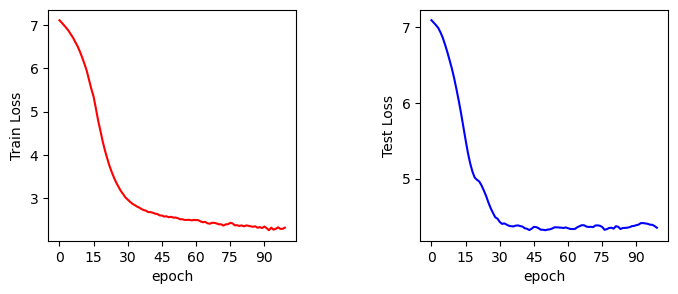

In [11]:
from matplotlib import pyplot as plt, ticker
from torch import optim
from tqdm import tqdm

input_dim = len(src_vocab)
output_dim = len(tgt_vocab)
enc_emd_dim = 256
dec_emb_dim = 512
hid_dim = 512
n_layers = 2
enc_dropout = 0.5
dec_dropout = 0.5

print("input_dim: {} \t output_dim: {} \t enc_bed_dim: {} \t dec_emb_dim: {}\t".format(input_dim, output_dim, enc_emd_dim, dec_emb_dim))

enc = Encoder(input_dim, enc_emd_dim, hid_dim, n_layers, enc_dropout)
dec = Decoder(output_dim, dec_emb_dim, hid_dim, n_layers, dec_dropout)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = Seq2Seq(enc, dec, device).to(device)

optimizer = optim.Adam(model.parameters(), lr = 0.00001)
criterion = nn.CrossEntropyLoss(ignore_index=tgt_vocab['<pad>'])

print(f"\n模型在{device}上训练")

def train(model, train_loader, optimizer, criterion, clip):
    model.train()

    epoch_loss = 0

    for i, batch in enumerate(train_loader):
        src, trg = batch
        src, trg = src.to(device), trg.to(device)
        
        src, trg = torch.transpose(src, 0, 1), torch.transpose(trg, 0, 1)

        optimizer.zero_grad()

        output = model(src, trg)

        output_dim = output.shape[-1]

        output = output[1:].view(-1, output_dim)

        trg = trg[1:].reshape(-1)

        loss = criterion(output, trg)

        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)

        optimizer.step()

        epoch_loss += loss.item()

    return epoch_loss / len(train_loader)

def evaluate(model, data_iter, criterion):
    model.eval()

    epoch_loss = 0

    with torch.no_grad():
        for i, batch in enumerate(data_iter):
            src, trg = batch
            src, trg = src.to(device), trg.to(device)
            
            src, trg = torch.transpose(src, 0, 1), torch.transpose(trg, 0, 1)

            output = model(src, trg, 0)

            output_dim = output.shape[-1]

            output = output[1:].view(-1, output_dim)
            trg = trg[1:].reshape(-1)

            loss = criterion(output, trg)

            epoch_loss += loss.item()

    return epoch_loss / len(data_iter)

epocees = 100
CLIP = 1

tot_loss_train = []
tot_loss_test = []
for epoch in tqdm(range(epocees)):
    train_loss = train(model, train_loader, optimizer, criterion, CLIP)
    test_loss = evaluate(model, test_loader, criterion)

    if (epoch + 1) % 10 == 0:
        print(f'Epoch: {epoch+1:02} \t 训练损失: {train_loss:.3f} \t 测试损失: {test_loss:.3f}')
    tot_loss_train.append(train_loss)
    tot_loss_test.append(test_loss)
    
_, axes = plt.subplots(1, 2, figsize=(8, 3))
axes[0].plot(range(len(tot_loss_train)), tot_loss_train, c='r') 
axes[0].set_xlabel("epoch")
axes[0].set_ylabel("Train Loss")
axes[0].yaxis.set_major_locator(ticker.MaxNLocator(integer=True))
axes[0].xaxis.set_major_locator(ticker.MaxNLocator(integer=True))

axes[1].plot(range(len(tot_loss_test)), tot_loss_test, c='b')
axes[1].set_xlabel("epoch")
axes[1].set_ylabel("Test Loss")
axes[1].yaxis.set_major_locator(ticker.MaxNLocator(integer=True))
axes[1].xaxis.set_major_locator(ticker.MaxNLocator(integer=True))

plt.subplots_adjust(wspace=0.5)
plt.show()